In [4]:
import os
import numpy as np


def find_best(checkpoint, task):
    log_files_a = os.listdir(checkpoint+"/")
    log_files_b = []

    for file in log_files_a:
        file_split = file.split(".")
        if(file_split[-1]=="txt"):
            file_split_2 = file_split[0].split("_")
            if(file_split_2[0]=="session" and file_split_2[1]==str(task) ):
                f = np.loadtxt(checkpoint+"/"+file, skiprows=1)
                best_acc = max(f[-1,-1], f[-1,-2])
                if(file_split_2[-1]!="RT"):
                    return best_acc
                    
    return best_acc


In [5]:
##### import numpy as np
from collections import Counter

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)**(1/2) 
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def get_correct(acc_task, task, chunks, start_point, class_per_task):
        correct = 0
        correct2 = 0
        task_scores = []
        class_scores = []
        targets = []
        targets_pred = []
        for t in range(task+1):
            list_0 = []
            list_1 = []
            list_2 = []
            list_3 = []
            for i in range(chunks):
                acc_task_0 = acc_task[start_point + i]
                list_0.append(acc_task_0[t][0].detach().cpu().numpy())
                list_1.append(acc_task_0[t][1].detach().cpu().numpy())
                list_2.append(acc_task_0[t][2])
                list_3.append(acc_task_0[t][3].detach().cpu().numpy())
            list_0 = np.array(list_0)
            list_1 = np.array(list_1)
            list_2 = np.array(list_2)
            list_3 = np.array(list_3)
            
            targets_pred.append(list_0)
            class_scores.append(list_1)
            task_scores.append(list_2)
            targets.append(list_3)
            
        m = task_scores[0]
        task_scores2 = []
        for t2 in range(task+1):
            m2 = m[:,t2:(t2+1)]
            m3 = np.max(m2, 1)
            task_scores2.append(np.mean(m3))
        pred_task = np.argmax(task_scores2)  
        if(pred_task == targets[0][0]//class_per_task):
            correct2 += chunks
            for j in range(chunks):
                local_t = np.argmax(class_scores[pred_task][j])
                pred_x = [targets_pred[pred_task][j][local_t]]
                target_x = targets[0][j]
                if(target_x in pred_x+pred_task*class_per_task):
                    correct += 1 
#         else:
#             print(pred_task, targets[0][0]//class_per_task)
        return correct, correct2
    
def get_mata_score(p, task, chunks):
    task_samples = {0: 5000, 1: 5000}
    total_samples = np.sum([task_samples[x] for x in range(task+1)])
    class_per_task = 50
    with open(p + "/meta_task_test_list_"+str(task)+".pickle", 'rb') as handle:
        acc_task = pickle.load(handle)
    correct = 0
    correct2= 0
    for tt in range(task+1):
        ctask_samples = np.sum([task_samples[x] for x in range(tt)])
        for class_id in range(task_samples[tt]//chunks):
            start_point = ctask_samples + class_id*chunks
            c, c2 = get_correct(acc_task, task, chunks, start_point, class_per_task)
            correct += c
            correct2 += c2

        new_chunk = task_samples[tt]-(class_id+1)*chunks
        if(new_chunk>0):
            start_point = ((task_samples[tt]//chunks)*chunks)
            c, c2 = get_correct(acc_task, t, new_chunk, start_point, class_per_task)
            correct += c
            correct2 += c2
    return correct/total_samples*100, correct2/total_samples*100

# print(get_mata_score("models/cifar100/meta2_cifar_T2_10", 0, 20) )           

In [25]:
models_dic = [
    ["results/cifar100/meta2_cifar_T2_10",       "brown",          "Base :  1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=1",       "<-"   ],  
]

77.02,69.51


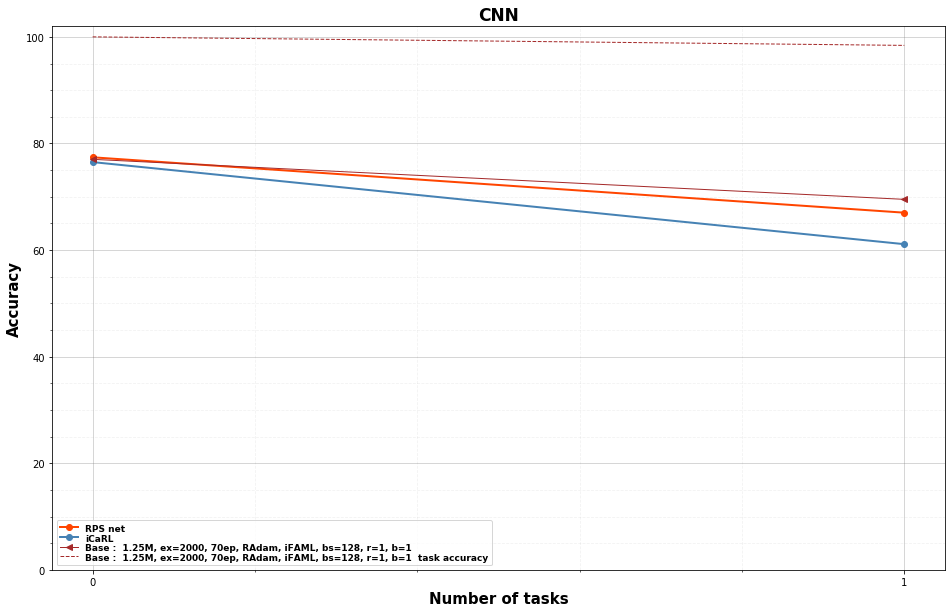

In [36]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
x = range(2)

icarl = [76.5, 61.1]
ours = [77.4, 67.01]


plt.figure(figsize=(16,10))
chunks = 20

plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="RPS net")
plt.plot(x, icarl, "o-", linewidth=2, c="steelblue", label="iCaRL")


for i,p in enumerate(models_dic):
    z = np.zeros_like(list(x))*0.0
    z2 = np.zeros_like(list(x))*0.0
    ps = "models/" + "/".join(p[0].split("/")[1:])
    try:
        z = np.load(p[0]+"/meta_x"+str(chunks)+".npy")
        z2 = np.load(p[0]+"/meta_task_"+str(chunks)+".npy")
    except:
        for j in range(2):
            try:
                z[j], z2[j] = get_mata_score(ps , j, chunks)
            except Exception as e:
                print(e)
                pass
        np.save(p[0]+"/meta_"+str(chunks)+".npy", z)
        np.save(p[0]+"/meta_task_"+str(chunks)+".npy", z2)
        
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    plt.plot(x, z2, "--", linewidth=1, c = p[1], label=p[2] + "  task accuracy")
    print(",".join([str(i) for i in z]) )
    
plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,102])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("CNN", fontweight='bold', fontsize=17) 
plt.xticks(range(2))
# plt.savefig("meta_2.pdf")
plt.show()

89.1,88.85,87.03333333333332,86.25,84.7,82.83333333333333,81.14285714285714,80.125,79.16666666666667,79.20000000000002
90.89999999999999,89.15,89.83333333333333,87.5,86.08000000000001,85.25,83.88571428571427,83.0375,81.61111111111111,81.68999999999998
90.5,88.75,87.2,86.425,85.1,83.93333333333334,82.20000000000002,81.625,80.86666666666666,80.7
89.2,88.0,87.63333333333334,86.2,85.36,83.88333333333333,82.28571428571429,82.0,81.38888888888889,81.09
85.39999999999999,77.05000000000001,84.33333333333333,84.30000000000001,83.14,81.45,80.25714285714285,79.36250000000001,78.4111111111111,78.79
85.9,76.00000000000001,83.0,83.975,83.22,81.7,80.55714285714285,79.55,78.61111111111113,78.54
89.5,88.4,87.3,86.125,84.35999999999999,81.8,80.32857142857144,79.3125,78.45555555555555,78.13000000000001


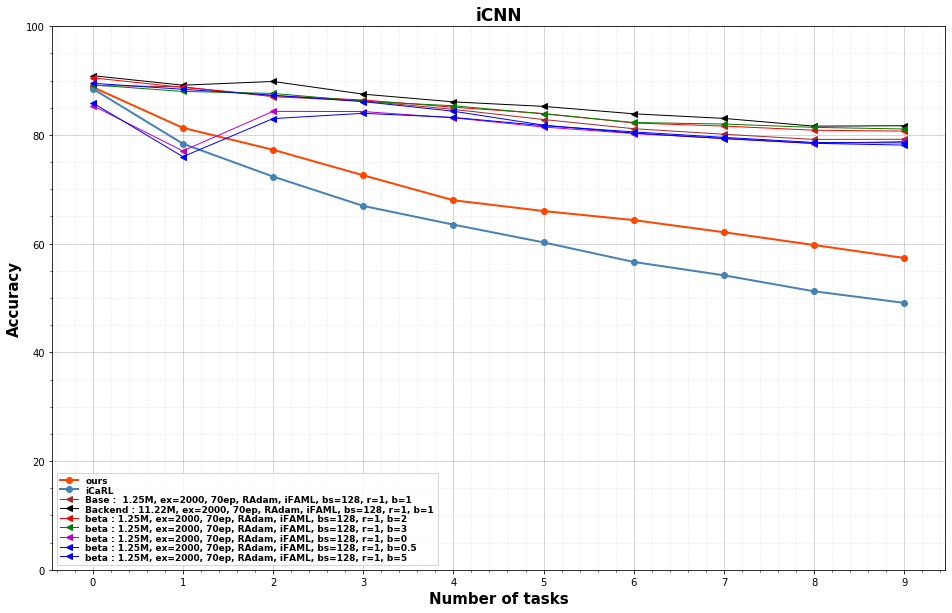

In [277]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
x = range(10)
icarl = [88.5, 78.39, 72.34, 66.94, 63.50, 60.23, 56.63, 54.17, 51.23, 49.10]
ours = [88.8, 81.3, 77.266667, 72.575, 67.98, 66.0, 64.328571, 62.1, 59.744444, 57.36]

plt.figure(figsize=(16,10))

plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="ours")
plt.plot(x, icarl, "o-", linewidth=2, c="steelblue", label="iCaRL")

for i,p in enumerate(models_dic):
    z = np.zeros_like(icarl)
    ps = "models/" + "/".join(p[0].split("/")[1:])
    for j in range(len(icarl)):
        try:
            with open(ps + "/acc_task_"+str(j)+".pickle", 'rb') as handle:
                acc_task = pickle.load(handle)
            z[j] = np.sum([acc_task[x] for x in range(j+1)])/(j+1)
        except Exception as e:
#             print(e)
            pass
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    print(",".join([str(i) for i in z]) )
    
plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,100])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("iCNN", fontweight='bold', fontsize=17) 
plt.xticks(range(10))
# plt.savefig("reptile.pdf")
plt.show()

83.3,69.05,56.6,48.0,42.21,0.0,0.0,0.0,0.0,0.0


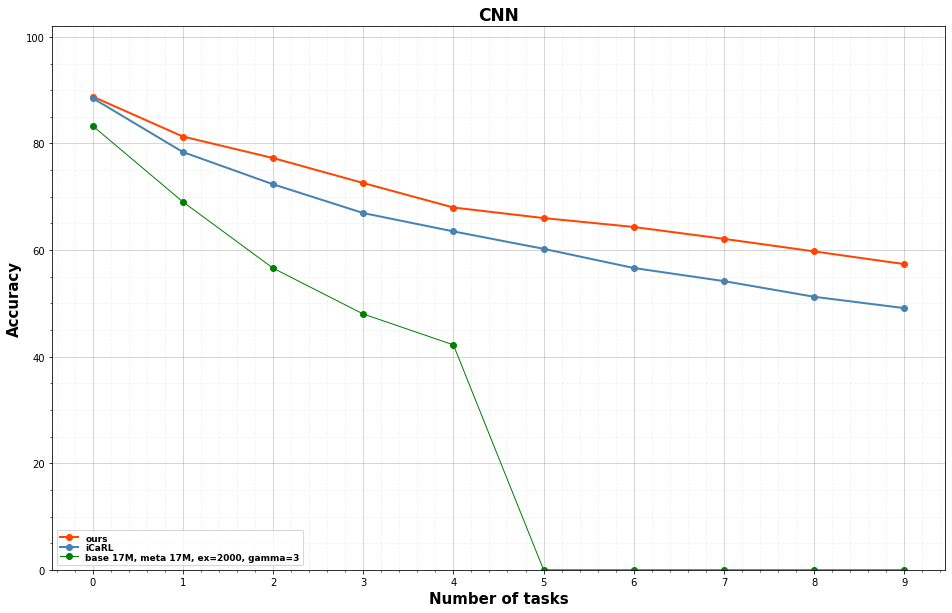

In [18]:
import matplotlib.pyplot as plt 
import numpy as np
x = range(10)
icarl = [88.5, 78.39, 72.34, 66.94, 63.50, 60.23, 56.63, 54.17, 51.23, 49.10]
ours = [88.8, 81.3, 77.266667, 72.575, 67.98, 66.0, 64.328571, 62.1, 59.744444, 57.36]

plt.figure(figsize=(16,10))

plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="ours")
plt.plot(x, icarl, "o-", linewidth=2, c="steelblue", label="iCaRL")

for i,p in enumerate(models_dic):
    z = np.zeros_like(icarl)
    for j in range(len(icarl)):
        try:
            z[j] = find_best(p[0], j)
        except Exception as e:
#             print(e)
            pass

    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    print(",".join([str(i) for i in z]) )
    
plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,102])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("CNN", fontweight='bold', fontsize=17) 
plt.xticks(range(10))
# plt.savefig("reptile.pdf")
plt.show()

In [6]:
import scipy
import numpy as np
import pickle
def comb(a,b):
    aa = scipy.math.factorial(a)
    bb = scipy.math.factorial(b)
    ab = scipy.math.factorial(a-b)
    return aa/bb/ab

def binomial_prob(n,r,p):    
    if(n>=r):
        return comb(n,r)* (p**(r))* ((1-p)**(n-r))
    else:return 0


num_task = 2
total_num_class = 100
class_per_task = total_num_class//num_task

for t in [1]:
    task = t
    ps = "results/cifar100/meta2_cifar_T2_10"
    
    task_samples = {0: 5000, 1: 5000}
    total_samples = np.sum([task_samples[x] for x in range(t+1)])

    with open("models/" + "/".join(ps.split("/")[1:]) + "/meta_task_test_list_"+str(t)+".pickle", 'rb') as handle:
        acc_task = pickle.load(handle)
    
    with open("models/" + "/".join(ps.split("/")[1:]) + "/acc_task_test_"+str(t)+".pickle", 'rb') as handle:
        acc_test = pickle.load(handle)
    
    range_acc = (max(acc_test.values())-min(acc_test.values()))/100
    p0 = np.mean(list(acc_test.values()))/100
    p0 = (p0 - range_acc/2)

    p0_hat = p0 + (1-p0)/((class_per_task*(t+1))-1)*(class_per_task-1)
    print(p0, p0_hat)
    found = 0
    for chunk in range(2,50):
        p = 0
        for j in range(max((2*int(chunk/(task+1))),2),chunk+1):
            p += binomial_prob(chunk,j, p0_hat)
        if(p>=0.95):
            found = 1
            break

    
    for chunks in [chunk]:
        correct = 0
        correct2= 0
        for tt in range(task+1):
            ctask_samples = np.sum([task_samples[x] for x in range(tt)])
            for class_id in range(task_samples[tt]//chunks):
                start_point = ctask_samples + class_id*chunks
                c, c2 = get_correct(acc_task, t, chunks, start_point, class_per_task)
                correct += c
                correct2 += c2
            
            new_chunk = task_samples[tt]-(class_id+1)*chunks
            if(new_chunk>0):
                start_point = ((task_samples[tt]//chunks)*chunks)
                c, c2 = get_correct(acc_task, t, new_chunk, start_point, class_per_task)
                correct += c
                correct2 += c2
    
    print("task = ", t, "\t", 
          "chunk = ", chunk,j, "\t", 
          "predicted accuracy = ", p, "\t", 
          "actual task accuracy = ", correct2/total_samples*100, "\t",
          "actual class accuracy = ", correct/total_samples*100, "\t",
         )



0.5500000000000002 0.7727272727272728
task =  1 	 chunk =  49 49 	 predicted accuracy =  5.0250241950668574e-05 	 actual task accuracy =  99.96000000000001 	 actual class accuracy =  70.58 	


In [21]:
t = 1
class_per_task = 50
range_acc = (max(list(acc_test.values()))-min(list(acc_test.values())))/100
p0 = np.mean(list(acc_test.values()))/100
# p0 = (p0 - 0.36*range_acc)
p0 = (p0 - range_acc*(1-np.exp(-1)))

p0_hat = p0 + (1-p0)/((class_per_task*(t+1))-1)*(class_per_task-1) 
print(p0, p0_hat, range_acc)

for chunk in range(2,50):
    p = 0
    for j in range(int(np.around(chunk//(task+1))+1),chunk+1):
#     for j in range(3,chunk+1):
        p += binomial_prob(chunk,j, p0_hat)
    print(p, chunk)
    if(p>=0.95):
        found = 1
        break

0.5466969860292862 0.7710590838531748 0.025
0.5945321107924972 2
0.8667575630395774 3
0.7732722463856818 4
0.9174376516114352 5
0.8624287183629982 6
0.9472589937115589 7
0.9132720320398066 8
0.9656839430989549 9


In [33]:
for chunks in [9]:
    correct = 0
    correct2= 0
    for tt in range(task+1):
        ctask_samples = np.sum([task_samples[x] for x in range(tt)])
        for class_id in range(task_samples[tt]//chunks):
            start_point = ctask_samples + class_id*chunks
            c, c2 = get_correct(acc_task, t, chunks, start_point, class_per_task)
            correct += c
            correct2 += c2

        new_chunk = task_samples[tt]-(class_id+1)*chunks
        if(new_chunk>0):
            start_point = ((task_samples[tt]//chunks)*chunks)
            c, c2 = get_correct(acc_task, t, new_chunk, start_point, class_per_task)
            correct += c
            correct2 += c2

print("task = ", t, "\t", 
      "chunk = ", chunks,j, "\t", 
      "predicted accuracy = ", p, "\t", 
      "actual task accuracy = ", correct2/total_samples*100, "\t",
      "actual class accuracy = ", correct/total_samples*100, "\t",
     )


task =  1 	 chunk =  9 9 	 predicted accuracy =  0.9666940588665555 	 actual task accuracy =  94.42 	 actual class accuracy =  66.88 	


In [121]:
a = np.load("results/cifar100/meta2_cifar_T10_60/seed.npy")
print(a)

4730
